# Summary of Allreduce between Nodes

In [1]:
%matplotlib inline
import glob
import os
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

SAVE_FIGURE = False
FIGURE_FONT_SIZE = 12

plt.rcParams["figure.dpi"] = 120
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = FIGURE_FONT_SIZE
pd.set_option('display.max_columns', 30)


project_dir = os.getcwd()
dir_anode_results = f'{project_dir}/inter_anode'
dir_vnode_results = f'{project_dir}/inter_vnode'

In [2]:
# function definitions

def read_data_from_file(filepath, name=None):
    if filepath.endswith('nccl'):
        is_nccl_file = True
    else:
        is_nccl_file = False
    lines = []
    with open(filepath) as inf:
        for line in inf:
            line = line.strip()
            if line == '' or line.startswith('#'):
                continue
            if is_nccl_file and line.startswith('['):
                continue
            lines.append(line)

    index = [int(line.split()[0]) for line in lines]
    if is_nccl_file:
        data = [float(line.split()[4]) for line in lines]
    else:
        data = [float(line.split()[1]) for line in lines]
    return pd.Series(data=data, index=index, name=name)

def load_data():
    node_types = {
        'anode': dir_anode_results,
        'vnode': dir_vnode_results
    }
    methods = {
        'mpi-gpu': 'mpi',
        'mpi-cpu': 'mpi-cpu',
        'nccl': 'nccl'
    }
    nnodes = [2, 4, 8, 16, 32]

    series = []
    for method, suffix in methods.items():
        for node, dirpath in node_types.items():
            for nnode in nnodes:
                column_key = f'{method}:{node}:{nnode}'
                file_pattern = f'{dirpath}/job{nnode:02d}.sh.*.{suffix}'
                files = glob.glob(file_pattern)
                if not files:
                    continue
                data = read_data_from_file(files[0], column_key)
                series.append(data)
    return pd.concat(series, axis=1)

def plot(data, column_labels, markers, title, legend_fontsize=None):
    def _xticks_labels():
        idxs = [4, 8, 12, 16, 20, 24]
        xticks = [2**i for i in idxs]
        labels = []
        for val in xticks:
            if val < 1024:
                labels.append(str(val))
            elif val < 1024 * 1024:
                labels.append(str(val // 1024) + 'K')
            else:
                labels.append(str(val // 1024 // 1024) + 'M')
        return xticks, labels

    data0 = data[column_labels.keys()]
    data0 = data0.rename(columns=column_labels)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.set_xlabel('Message Size (Bytes)')
    ax.set_xscale('log', base=2)
    xticks, xticklabels = _xticks_labels()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax.set_ylabel('Time (Micro-second)')
    ax.set_yscale('log')

    data0.plot(ax=ax, style=markers)
    ax.legend(fontsize=legend_fontsize)
    if SAVE_FIGURE:
        fig.savefig(f'{title}.pdf')
    ax.set_title(title)

In [3]:
data = load_data()
data

,mpi-gpu:anode:2,mpi-gpu:anode:4,mpi-gpu:anode:8,mpi-gpu:anode:16,mpi-gpu:vnode:2,mpi-gpu:vnode:4,mpi-gpu:vnode:8,mpi-gpu:vnode:16,mpi-gpu:vnode:32,mpi-cpu:anode:2,mpi-cpu:anode:4,mpi-cpu:anode:8,mpi-cpu:anode:16,mpi-cpu:vnode:2,mpi-cpu:vnode:4,mpi-cpu:vnode:8,mpi-cpu:vnode:16,mpi-cpu:vnode:32,nccl:anode:2,nccl:anode:4,nccl:anode:8,nccl:anode:16,nccl:vnode:2,nccl:vnode:4,nccl:vnode:8,nccl:vnode:16,nccl:vnode:32
4,32.00,34.68,37.23,38.57,28.53,28.01,31.31,32.42,36.05,3.27,5.54,7.08,9.20,3.00,4.34,6.21,7.98,10.38,34.52,43.78,55.14,68.79,18.83,31.48,41.25,52.21,61.68
8,31.97,34.08,36.49,38.44,28.56,28.18,31.38,32.49,35.15,3.25,5.53,6.92,9.12,2.99,4.32,6.05,7.56,10.17,33.28,42.37,51.29,62.33,18.59,30.79,40.88,51.50,60.38
16,32.30,34.65,36.73,38.65,28.83,28.39,31.46,32.80,35.06,3.27,5.54,6.89,9.24,2.99,4.31,6.05,7.54,10.13,32.82,42.51,51.35,63.09,18.50,30.91,41.36,51.53,61.65
32,32.66,34.73,37.13,39.18,27.84,28.76,30.76,33.38,36.78,3.59,5.70,7.29,9.55,3.36,4.54,6.55,8.05,10.67,32.50,42.57,51.36,62.34,18.62,30.71,40.95,51.39,61.37
64,36.15,38.55,40.80,42.64,27.65,29.47,30.85,33.68,36.28,3.92,6.16,7.98,10.00,3.69,4.98,7.03,8.50,11.48,32.84,43.41,51.81,62.15,18.95,31.40,41.56,52.55,62.00
128,33.91,36.07,49.84,69.15,28.04,29.95,31.52,34.39,37.09,4.73,6.86,8.90,10.91,3.99,5.42,7.35,9.01,11.64,32.71,44.45,52.48,62.87,19.21,32.14,42.46,53.67,63.82
256,34.28,38.92,40.45,45.06,28.86,31.62,33.40,36.82,40.20,5.13,7.53,10.07,12.48,4.55,6.49,8.59,11.18,13.94,34.19,46.77,55.08,65.52,19.40,32.44,43.07,54.13,64.54
512,34.94,38.70,41.13,47.59,29.32,31.93,33.59,37.58,40.20,5.61,8.03,10.72,13.16,4.97,6.92,9.21,11.59,15.10,34.96,47.35,56.87,67.43,19.96,34.42,45.01,56.85,68.09
1024,36.01,38.83,44.21,47.72,30.56,33.46,35.71,39.80,42.30,6.08,8.90,11.65,14.26,5.62,8.05,10.19,13.29,17.06,36.23,51.36,62.96,73.24,23.62,37.49,49.77,62.68,75.09
2048,38.62,43.28,45.90,50.09,33.42,38.29,40.27,44.33,47.70,8.25,11.79,14.90,18.02,7.61,10.95,13.70,17.24,20.74,38.17,53.82,66.05,77.15,24.77,43.32,57.88,73.22,87.49


## Node(A) vs. Node(V)

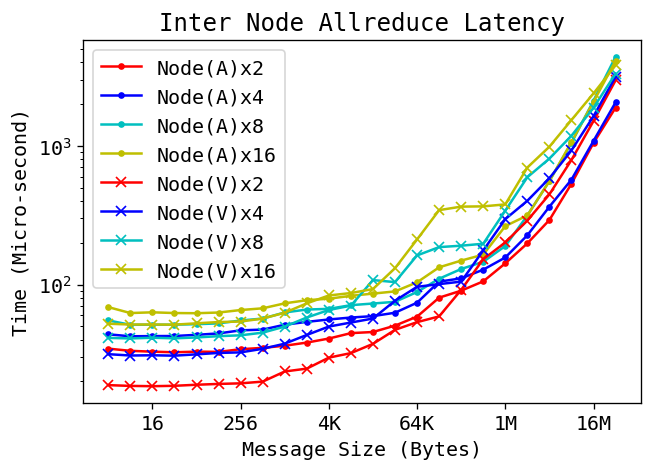

In [4]:
title = 'Inter Node Allreduce Latency'
column_labels = {
    'nccl:anode:2': 'Node(A)x2',
    'nccl:anode:4': 'Node(A)x4',
    'nccl:anode:8': 'Node(A)x8',
    'nccl:anode:16': 'Node(A)x16',
    'nccl:vnode:2': 'Node(V)x2',
    'nccl:vnode:4': 'Node(V)x4',
    'nccl:vnode:8': 'Node(V)x8',
    'nccl:vnode:16': 'Node(V)x16',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'rx-', 'bx-', 'cx-', 'yx-']
plot(data, column_labels, markers, title)

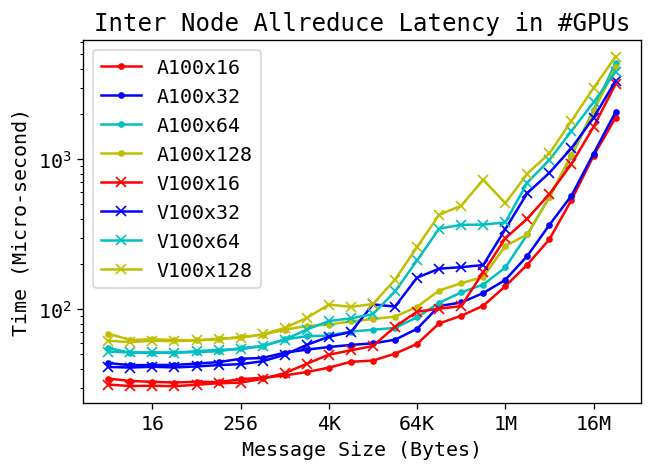

In [5]:
title = 'Inter Node Allreduce Latency in #GPUs'
column_labels = {
    'nccl:anode:2': 'A100x16',
    'nccl:anode:4': 'A100x32',
    'nccl:anode:8': 'A100x64',
    'nccl:anode:16': 'A100x128',
    'nccl:vnode:4': 'V100x16',
    'nccl:vnode:8': 'V100x32',
    'nccl:vnode:16': 'V100x64',
    'nccl:vnode:32': 'V100x128',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'rx-', 'bx-', 'cx-', 'yx-']
plot(data, column_labels, markers, title)

## Performance Differences by Communication Methods of Node(A)

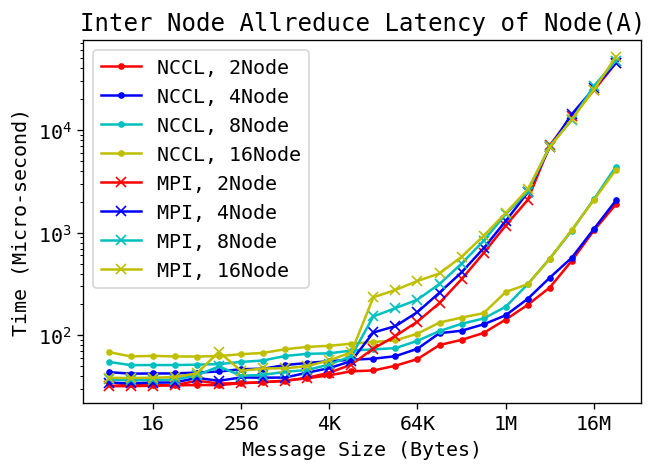

In [6]:
title = 'Inter Node Allreduce Latency of Node(A)'
column_labels = {
    'nccl:anode:2': 'NCCL, 2Node',
    'nccl:anode:4': 'NCCL, 4Node',
    'nccl:anode:8': 'NCCL, 8Node',
    'nccl:anode:16': 'NCCL, 16Node',
    'mpi-gpu:anode:2': 'MPI, 2Node',
    'mpi-gpu:anode:4': 'MPI, 4Node',
    'mpi-gpu:anode:8': 'MPI, 8Node',
    'mpi-gpu:anode:16': 'MPI, 16Node',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'rx-', 'bx-', 'cx-', 'yx-']
plot(data, column_labels, markers, title)

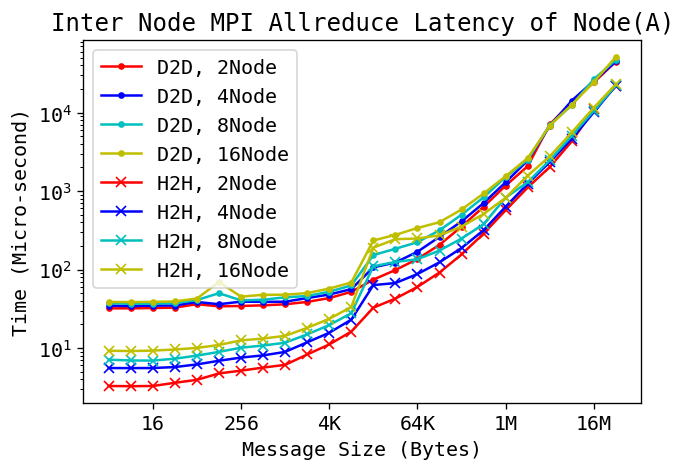

In [7]:
title = 'Inter Node MPI Allreduce Latency of Node(A)'
column_labels = {
    'mpi-gpu:anode:2': 'D2D, 2Node',
    'mpi-gpu:anode:4': 'D2D, 4Node',
    'mpi-gpu:anode:8': 'D2D, 8Node',
    'mpi-gpu:anode:16': 'D2D, 16Node',
    'mpi-cpu:anode:2': 'H2H, 2Node',
    'mpi-cpu:anode:4': 'H2H, 4Node',
    'mpi-cpu:anode:8': 'H2H, 8Node',
    'mpi-cpu:anode:16': 'H2H, 16Node',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'rx-', 'bx-', 'cx-', 'yx-']
plot(data, column_labels, markers, title)

## Performance Differences by Communication Methods of Node(V)

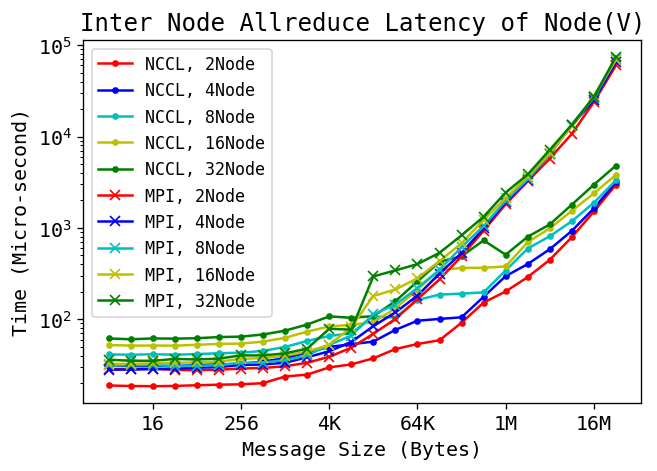

In [8]:
title = 'Inter Node Allreduce Latency of Node(V)'
column_labels = {
    'nccl:vnode:2': 'NCCL, 2Node',
    'nccl:vnode:4': 'NCCL, 4Node',
    'nccl:vnode:8': 'NCCL, 8Node',
    'nccl:vnode:16': 'NCCL, 16Node',
    'nccl:vnode:32': 'NCCL, 32Node',
    'mpi-gpu:vnode:2': 'MPI, 2Node',
    'mpi-gpu:vnode:4': 'MPI, 4Node',
    'mpi-gpu:vnode:8': 'MPI, 8Node',
    'mpi-gpu:vnode:16': 'MPI, 16Node',
    'mpi-gpu:vnode:32': 'MPI, 32Node',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'g.-', 'rx-', 'bx-', 'cx-', 'yx-', 'gx-']
plot(data, column_labels, markers, title, legend_fontsize=10)

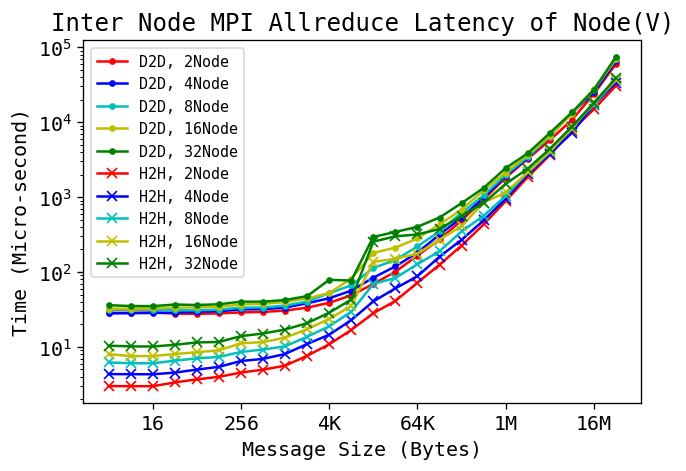

In [9]:
title = 'Inter Node MPI Allreduce Latency of Node(V)'
column_labels = {
    'mpi-gpu:vnode:2': 'D2D, 2Node',
    'mpi-gpu:vnode:4': 'D2D, 4Node',
    'mpi-gpu:vnode:8': 'D2D, 8Node',
    'mpi-gpu:vnode:16': 'D2D, 16Node',
    'mpi-gpu:vnode:32': 'D2D, 32Node',

    'mpi-cpu:vnode:2': 'H2H, 2Node',
    'mpi-cpu:vnode:4': 'H2H, 4Node',
    'mpi-cpu:vnode:8': 'H2H, 8Node',
    'mpi-cpu:vnode:16': 'H2H, 16Node',
    'mpi-cpu:vnode:32': 'H2H, 32Node',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'g.-', 'rx-', 'bx-', 'cx-', 'yx-', 'gx-']
plot(data, column_labels, markers, title, legend_fontsize=9)